# Priority Signal Validation Experiment

Validates whether masterclass teaching moments (STOP/CONTINUE) can be predicted from audio.

- **Model B:** Logistic regression on 19 PercePiano quality scores
- **Model A:** Logistic regression on 2048-dim MuQ embeddings
- **Evaluation:** Leave-one-video-out cross-validation (5 folds)

Design doc: `docs/plans/2026-02-14-priority-signal-validation-design.md`

In [1]:
import sys
from pathlib import Path
import numpy as np
import torch

# Add src to path
MODEL_ROOT = Path("../..").resolve()
sys.path.insert(0, str(MODEL_ROOT / "src"))

from masterclass_experiments.data import load_moments, identify_segments, extract_audio_segments
from masterclass_experiments.features import extract_muq_features, extract_quality_scores, stats_pool
from masterclass_experiments.evaluation import leave_one_video_out_cv

In [2]:
REPO_ROOT = MODEL_ROOT.parent
MOMENTS_PATH = REPO_ROOT / "tools" / "masterclass-pipeline" / "all_moments.jsonl"
WAV_DIR = REPO_ROOT / "tools" / "masterclass-pipeline" / "data" / "audio"
CACHE_DIR = MODEL_ROOT / "data" / "masterclass_cache"
SEGMENT_DIR = CACHE_DIR / "segments"
MUQ_CACHE_DIR = CACHE_DIR / "muq_embeddings"

# A2_pianoteq_ensemble: best model from ISMIR paper (R^2=0.537, soundfont-augmented)
CHECKPOINT_DIR = MODEL_ROOT / "data" / "checkpoints" / "percepiano"
CHECKPOINT_PATHS = sorted(CHECKPOINT_DIR.glob("fold*_best.ckpt"))

for d in [SEGMENT_DIR, MUQ_CACHE_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Moments: {MOMENTS_PATH}")
print(f"WAV dir: {WAV_DIR}")
print(f"Checkpoints: {len(CHECKPOINT_PATHS)} folds from {CHECKPOINT_DIR}")

Moments: /Users/jdhiman/Documents/crescendai/tools/masterclass-pipeline/all_moments.jsonl
WAV dir: /Users/jdhiman/Documents/crescendai/tools/masterclass-pipeline/data/audio
Checkpoints: 3 folds from /Users/jdhiman/Documents/crescendai/model/data/checkpoints/percepiano


In [3]:
# Load and explore moments
moments = load_moments(MOMENTS_PATH)
print(f"Loaded {len(moments)} moments")

# Identify segments
segments = identify_segments(moments)
stop_segments = [s for s in segments if s.label == "stop"]
cont_segments = [s for s in segments if s.label == "continue"]
print(f"STOP segments: {len(stop_segments)}")
print(f"CONTINUE segments: {len(cont_segments)}")

# Duration stats
for label, segs in [("STOP", stop_segments), ("CONTINUE", cont_segments)]:
    durations = [s.end_time - s.start_time for s in segs]
    print(f"{label}: mean={np.mean(durations):.1f}s, median={np.median(durations):.1f}s, "
          f"min={np.min(durations):.1f}s, max={np.max(durations):.1f}s")

# Extract audio segments
extract_audio_segments(segments, WAV_DIR, SEGMENT_DIR)
print(f"Audio segments saved to {SEGMENT_DIR}")

Loaded 65 moments
STOP segments: 61
CONTINUE segments: 37
STOP: mean=17.7s, median=14.7s, min=3.5s, max=66.7s
CONTINUE: mean=162.0s, median=126.1s, min=7.1s, max=706.2s
Audio segments saved to /Users/jdhiman/Documents/crescendai/model/data/masterclass_cache/segments


In [4]:
# Extract raw MuQ embeddings once (used by both Model A and Model B)
from audio_experiments.extractors.muq import MuQExtractor

print("Extracting MuQ embeddings...")
extractor = MuQExtractor(cache_dir=MUQ_CACHE_DIR)
raw_embeddings = {}
for seg in segments:
    wav_path = SEGMENT_DIR / f"{seg.segment_id}.wav"
    raw_embeddings[seg.segment_id] = extractor.extract_from_file(wav_path)
print(f"Extracted raw embeddings for {len(raw_embeddings)} segments")

# Stats pool for Model A features
muq_features = {sid: stats_pool(emb) for sid, emb in raw_embeddings.items()}
print(f"Stats-pooled MuQ features: {next(iter(muq_features.values())).shape}")

# Run PercePiano model for Model B features (averaged across all fold checkpoints)
print(f"Running PercePiano inference (ensemble of {len(CHECKPOINT_PATHS)} folds)...")
quality_scores = extract_quality_scores(raw_embeddings, CHECKPOINT_PATHS)
print(f"Extracted quality scores for {len(quality_scores)} segments")

Extracting MuQ embeddings...
Loading MuQ-large-msd-iter (last hidden state) on mps...


/Users/jdhiman/Documents/crescendai/model/.venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Model loaded. Hidden size: 1024
Extracted raw embeddings for 98 segments
Stats-pooled MuQ features: torch.Size([2048])
Running PercePiano inference (ensemble of 3 folds)...


/Users/jdhiman/Documents/crescendai/model/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.6.0, which is newer than your current Lightning version: v2.5.5


Extracted quality scores for 98 segments


In [5]:
from audio_experiments.constants import PERCEPIANO_DIMENSIONS

# Build feature matrices
segment_ids = np.array([s.segment_id for s in segments])
video_ids = np.array([s.video_id for s in segments])
labels = np.array([1 if s.label == "stop" else 0 for s in segments])

# Model B features: 19 quality scores
X_quality = np.stack([quality_scores[sid].numpy() for sid in segment_ids])
print(f"Model B features: {X_quality.shape}")

# Model A features: 2048-dim MuQ embeddings
X_muq = np.stack([muq_features[sid].numpy() for sid in segment_ids])
print(f"Model A features: {X_muq.shape}")

# Run leave-one-video-out CV
print("\n--- Model B (Quality Scores) ---")
results_b = leave_one_video_out_cv(X_quality, labels, video_ids, segment_ids)
print(f"AUC: {results_b['auc']:.3f}")
print(f"Accuracy: {results_b['accuracy']:.3f}")
print(f"Precision: {results_b['precision']:.3f}")
print(f"Recall: {results_b['recall']:.3f}")
print(f"Samples: {results_b['n_samples']} ({results_b['n_stop']} stop, {results_b['n_continue']} continue)")

print("\n--- Model A (MuQ Embeddings) ---")
results_a = leave_one_video_out_cv(X_muq, labels, video_ids, segment_ids)
print(f"AUC: {results_a['auc']:.3f}")
print(f"Accuracy: {results_a['accuracy']:.3f}")
print(f"Precision: {results_a['precision']:.3f}")
print(f"Recall: {results_a['recall']:.3f}")

Model B features: (98, 19)
Model A features: (98, 2048)

--- Model B (Quality Scores) ---
AUC: 0.814
Accuracy: 0.765
Precision: 0.806
Recall: 0.820
Samples: 98 (61 stop, 37 continue)

--- Model A (MuQ Embeddings) ---
AUC: 0.933
Accuracy: 0.888
Precision: 0.917
Recall: 0.902



--- False Negatives (Model B) ---
  stop_0091 (video ll0qDBCxCEc): proba=0.047
  stop_0093 (video ll0qDBCxCEc): proba=0.068
  stop_0082 (video ll0qDBCxCEc): proba=0.164
  stop_0097 (video ll0qDBCxCEc): proba=0.175
  stop_0065 (video jmJhV8Aj7oU): proba=0.206

--- False Positives (Model B) ---
  cont_0076 (video jmJhV8Aj7oU): proba=0.949
  cont_0070 (video jmJhV8Aj7oU): proba=0.946
  cont_0061 (video jmJhV8Aj7oU): proba=0.794
  cont_0078 (video jmJhV8Aj7oU): proba=0.791
  cont_0017 (video 7FTdGbVCPyQ): proba=0.758

--- Model B: Which quality dimensions predict STOP? ---
  articulation_length      : +1.498
  drama                    : -1.023
  balance                  : -0.961
  tempo                    : +0.926
  mood_valence             : +0.845
  timbre_brightness        : +0.843
  mood_energy              : -0.829
  space                    : +0.765
  mood_imagination         : -0.647
  timbre_depth             : -0.481
  pedal_clarity            : -0.463
  interpretation           

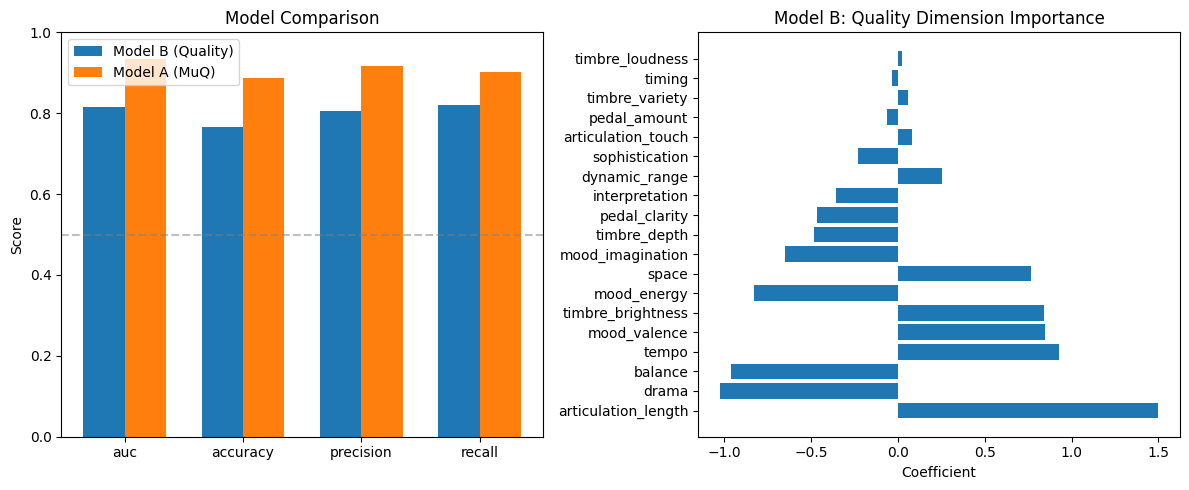

In [6]:
import matplotlib.pyplot as plt
from masterclass_experiments.models import train_classifier

# Comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

metrics = ["auc", "accuracy", "precision", "recall"]
model_b_vals = [results_b[m] for m in metrics]
model_a_vals = [results_a[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35
axes[0].bar(x - width/2, model_b_vals, width, label="Model B (Quality)")
axes[0].bar(x + width/2, model_a_vals, width, label="Model A (MuQ)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].set_ylabel("Score")
axes[0].set_title("Model Comparison")
axes[0].legend()
axes[0].axhline(y=0.5, color="gray", linestyle="--", alpha=0.5)
axes[0].set_ylim(0, 1)

# Qualitative: worst false negatives (teacher stopped but model said continue)
print("\n--- False Negatives (Model B) ---")
fn = [s for s in results_b["per_segment"] if s["y_true"] == 1 and s["y_pred_proba"] < 0.5]
fn.sort(key=lambda s: s["y_pred_proba"])
for s in fn[:5]:
    print(f"  {s['segment_id']} (video {s['video_id']}): proba={s['y_pred_proba']:.3f}")

print("\n--- False Positives (Model B) ---")
fp = [s for s in results_b["per_segment"] if s["y_true"] == 0 and s["y_pred_proba"] > 0.5]
fp.sort(key=lambda s: -s["y_pred_proba"])
for s in fp[:5]:
    print(f"  {s['segment_id']} (video {s['video_id']}): proba={s['y_pred_proba']:.3f}")

# Model B coefficient analysis (full-dataset refit for inspection only, not for reporting)
print("\n--- Model B: Which quality dimensions predict STOP? ---")
full_result = train_classifier(
    X_quality, labels, list(range(len(labels))), list(range(len(labels)))
)
coefs = full_result["coefficients"]
sorted_idx = np.argsort(np.abs(coefs))[::-1]
for i in sorted_idx:
    print(f"  {PERCEPIANO_DIMENSIONS[i]:25s}: {coefs[i]:+.3f}")

axes[1].barh(
    range(19),
    coefs[sorted_idx],
    tick_label=[PERCEPIANO_DIMENSIONS[i] for i in sorted_idx],
)
axes[1].set_xlabel("Coefficient")
axes[1].set_title("Model B: Quality Dimension Importance")
plt.tight_layout()
plt.show()